# Формирование выборки для SSL-pretext задачи из датасета BigP300BCI для дипломной работы

## Выборка для SSL-pretext

**Источник (Study)**: B + J + M + P + Q + R + S1 + S2
**Единица обработки**: один EDF-файл (record/run)

**Цель по объёму**

N_total = 500 000 эпох (таргет)

Хранение: Zarr, float32

Форма эпох: (C=14, L=фикс) (после ресэмпла/фильтра/epoch/pad)

**Сэмплинг эпох**

K_record = 150 эпох на EDF

Если в EDF доступно n_events < 150 → берём все

Если n_events >= 150 → выбираем 150 событий детерминированно (см. ниже)


**Дополнительный cap по субъекту** (чтобы не перекосило), фиксируем как ON

K_subject = 10 000 эпох на subject

Реализация: ведём счётчик, и когда субъект достиг 10k — пропускаем его дальнейшие EDF (или берём 0)

**Воспроизводимость**

Фиксируем GLOBAL_SEED = 2026 (можешь заменить на любой, но фиксируем один раз).

**Для каждого EDF:**

делаем record_seed = stable_hash(edf_relpath) XOR GLOBAL_SEED

rng = np.random.default_rng(record_seed)

chosen_idx = rng.choice(event_indices, size=min(150, n_events), replace=False)

сортируем chosen_idx по времени, чтобы порядок был стабильным

**Что именно режем в эпохи**

пересечение каналов с 14, реордер строго в одном порядке

ресэмпл к целевому fs_target

band-pass 0.1–20 Hz

epochs 0–800 ms от StimulusBegin (0→1)

pad/trim до фикс L

сохраняем в (N, 14, L) float32

**Формат Zarr**

ssl_bigp3bci.zarr/

X: (N, 14, L) float32, chunks (1024, 14, L) (или 2048 вместо 1024)

meta/study: (N,) (например, uint8 код)

meta/subject: (N,) (uint16/uint32 код)

meta/session: (N,) (uint16 или string-код)

meta/edf_id: (N,) (int32) — индекс в таблице records_index.csv

meta/t0_sample: (N,) int32 (onset в сэмплах после ресэмпла)

meta/y_stimtype: (N,) uint8 (0/1) — можно хранить, даже если SSL без меток (это не утечка, просто удобно для sanity-check)

Рядом кладём:

records_index.csv — список всех EDF, которые входили (study/subject/session/phase/path/num_events/и т.д.)

build_config.json — все параметры (каналы, fs, фильтр, окно, K_record, K_subject, seed)

### 0. Конфиг и константы

In [1]:
from pathlib import Path
import json

# ---- Paths ----

DATA_ROOT =  Path(r"C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\SSL_new")
RAW_ROOT = Path(r"C:\data_bigp3bci\bigP3BCI-data")
ZARR_PATH = DATA_ROOT / "ssl_bigp3bci.zarr"
INDEX_PATH = DATA_ROOT / "records_index.csv"
CONFIG_PATH = DATA_ROOT / "build_config.json"

# ---- Study split (SSL only here) ----
SSL_STUDIES = [
    "StudyB", "StudyJ", "StudyM", "StudyP",
    "StudyQ", "StudyR", "StudyS1", "StudyS2"
]

# ---- EEG config ----
TARGET_CHS = [
    "Fz","Cz","Pz","Oz","P3","P4","PO7","PO8",
    "F3","F4","C3","C4","CP3","CP4"
]

FS_TARGET = 256

EPOCH_TMIN = 0.0
EPOCH_TMAX = 0.8

L_FIXED = 208

# ---- Filtering ----
FMIN = 0.1
FMAX = 20.0

# ---- Sampling config ----
K_RECORD = 150
K_SUBJECT = 10_000
GLOBAL_SEED = 2026
N_TOTAL_TARGET = 500_000

# ---- Zarr config ----
ZARR_CHUNK_BATCH = 1024

# ---- Save config dict ----
CONFIG = {
    "ssl_studies": SSL_STUDIES,
    "target_channels": TARGET_CHS,
    "fs_target": FS_TARGET,
    "epoch_tmin": EPOCH_TMIN,
    "epoch_tmax": EPOCH_TMAX,
    "l_fixed": L_FIXED,
    "fmin": FMIN,
    "fmax": FMAX,
    "k_record": K_RECORD,
    "k_subject": K_SUBJECT,
    "global_seed": GLOBAL_SEED,
    "n_total_target": N_TOTAL_TARGET,
    "zarr_chunk_batch": ZARR_CHUNK_BATCH,
}

DATA_ROOT.mkdir(exist_ok=True, parents=True)

with open(CONFIG_PATH, "w") as f:
    json.dump(CONFIG, f, indent=2)

print("CONFIG SAVED")
print(CONFIG)

CONFIG SAVED
{'ssl_studies': ['StudyB', 'StudyJ', 'StudyM', 'StudyP', 'StudyQ', 'StudyR', 'StudyS1', 'StudyS2'], 'target_channels': ['Fz', 'Cz', 'Pz', 'Oz', 'P3', 'P4', 'PO7', 'PO8', 'F3', 'F4', 'C3', 'C4', 'CP3', 'CP4'], 'fs_target': 256, 'epoch_tmin': 0.0, 'epoch_tmax': 0.8, 'l_fixed': 208, 'fmin': 0.1, 'fmax': 20.0, 'k_record': 150, 'k_subject': 10000, 'global_seed': 2026, 'n_total_target': 500000, 'zarr_chunk_batch': 1024}


### 1. Индексация файлов 

In [2]:
import pandas as pd

records = []

for study in SSL_STUDIES:
    
    study_path = RAW_ROOT / study
    
    if not study_path.exists():
        print(f"⚠️ Study not found: {study_path}")
        continue
    
    # рекурсивный поиск всех EDF
    edf_files = list(study_path.rglob("*.edf"))
    
    print(f"{study}: {len(edf_files)} EDF")
    
    for edf_path in edf_files:
        
        relpath = edf_path.relative_to(RAW_ROOT)
        parts = relpath.parts
        
        # Ожидаем структуру Study / Subject / Session / ...
        # Берём первые элементы
        study_name = parts[0]
        subject = parts[1] if len(parts) > 1 else None
        session = parts[2] if len(parts) > 2 else None
        
        # phase = Train/Test если встречается в пути
        phase = None
        for p in parts:
            if p.lower() in ["train", "test"]:
                phase = p
        
        records.append({
            "study": study_name,
            "subject": subject,
            "session": session,
            "phase": phase,
            "relpath": str(relpath),
            "abspath": str(edf_path)
        })

# ---- DataFrame ----
df = pd.DataFrame(records)
df = df.sort_values(["study", "subject", "session", "relpath"]).reset_index(drop=True)

df["edf_id"] = df.index

print("TOTAL EDF:", len(df))
display(df.head())

# ---- Save ----
DATA_ROOT.mkdir(exist_ok=True, parents=True)
df.to_csv(INDEX_PATH, index=False)

print("INDEX SAVED:", INDEX_PATH)

StudyB: 544 EDF
StudyJ: 502 EDF
StudyM: 420 EDF
StudyP: 228 EDF
StudyQ: 720 EDF
StudyR: 480 EDF
StudyS1: 120 EDF
StudyS2: 288 EDF
TOTAL EDF: 3302


study subject session  phase  \
0  StudyB    B_01   SE001   Test   
1  StudyB    B_01   SE001   Test   
2  StudyB    B_01   SE001   Test   
3  StudyB    B_01   SE001  Train   
4  StudyB    B_01   SE001  Train   

                                             relpath  \
0  StudyB\B_01\SE001\Test\CB\B_01_SE001_CB_Test12...   
1  StudyB\B_01\SE001\Test\CB\B_01_SE001_CB_Test13...   
2  StudyB\B_01\SE001\Test\CB\B_01_SE001_CB_Test14...   
3  StudyB\B_01\SE001\Train\CB\B_01_SE001_CB_Train...   
4  StudyB\B_01\SE001\Train\CB\B_01_SE001_CB_Train...   

                                             abspath  edf_id  
0  C:\data_bigp3bci\bigP3BCI-data\StudyB\B_01\SE0...       0  
1  C:\data_bigp3bci\bigP3BCI-data\StudyB\B_01\SE0...       1  
2  C:\data_bigp3bci\bigP3BCI-data\StudyB\B_01\SE0...       2  
3  C:\data_bigp3bci\bigP3BCI-data\StudyB\B_01\SE0...       3  
4  C:\data_bigp3bci\bigP3BCI-data\StudyB\B_01\SE0...       4

INDEX SAVED: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\SSL_new\records_index.csv


In [3]:
df.groupby("study").size()

study
StudyB     544
StudyJ     502
StudyM     420
StudyP     228
StudyQ     720
StudyR     480
StudyS1    120
StudyS2    288
dtype: int64

### 2. Утилиты: стабильный seed и кодирование метаданных

In [4]:
import hashlib

# ---- stable hash ----
def stable_hash(s: str) -> int:
    h = hashlib.md5(s.encode("utf-8")).hexdigest()
    return int(h[:8], 16)  # uint32 достаточно


# ---- encoding dictionaries ----
study2id = {s: i for i, s in enumerate(sorted(df.study.unique()))}
subject2id = {s: i for i, s in enumerate(sorted(df.subject.unique()))}
session2id = {s: i for i, s in enumerate(sorted(df.session.unique()))}

print("studies:", len(study2id))
print("subjects:", len(subject2id))
print("sessions:", len(session2id))


# ---- apply encoding ----
df["study_id"] = df.study.map(study2id)
df["subject_id"] = df.subject.map(subject2id)
df["session_id"] = df.session.map(session2id)

# ---- record hash ----
df["record_hash"] = df.relpath.apply(stable_hash)

display(df.head())


# ---- save updated index ----
df.to_csv(INDEX_PATH, index=False)

# ---- update config ----
CONFIG["study2id"] = study2id
CONFIG["subject2id"] = subject2id
CONFIG["session2id"] = session2id

with open(CONFIG_PATH, "w") as f:
    json.dump(CONFIG, f, indent=2)

print("UPDATED INDEX + CONFIG SAVED")

studies: 8
subjects: 169
sessions: 10


study subject session  phase  \
0  StudyB    B_01   SE001   Test   
1  StudyB    B_01   SE001   Test   
2  StudyB    B_01   SE001   Test   
3  StudyB    B_01   SE001  Train   
4  StudyB    B_01   SE001  Train   

                                             relpath  \
0  StudyB\B_01\SE001\Test\CB\B_01_SE001_CB_Test12...   
1  StudyB\B_01\SE001\Test\CB\B_01_SE001_CB_Test13...   
2  StudyB\B_01\SE001\Test\CB\B_01_SE001_CB_Test14...   
3  StudyB\B_01\SE001\Train\CB\B_01_SE001_CB_Train...   
4  StudyB\B_01\SE001\Train\CB\B_01_SE001_CB_Train...   

                                             abspath  edf_id  study_id  \
0  C:\data_bigp3bci\bigP3BCI-data\StudyB\B_01\SE0...       0         0   
1  C:\data_bigp3bci\bigP3BCI-data\StudyB\B_01\SE0...       1         0   
2  C:\data_bigp3bci\bigP3BCI-data\StudyB\B_01\SE0...       2         0   
3  C:\data_bigp3bci\bigP3BCI-data\StudyB\B_01\SE0...       3         0   
4  C:\data_bigp3bci\bigP3BCI-data\StudyB\B_01\SE0...       4         0   

   subject_id  session_id  record_hash  
0           0           0    507071136  
1           0           0   1753054706  
2           0           0   4281778103  
3           0           0   2065262133  
4           0           0     98267628

UPDATED INDEX + CONFIG SAVED


### 3. Чтение одного EDF и извлечение событий

- загрузим один EDF

- посмотрим каналы

- извлечём StimulusBegin

- извлечём StimulusType

- убедимся, что событий разумное количество

In [6]:
import mne
import numpy as np

# ---- choose record ----
row = df.iloc[0]
edf_path = Path(row.abspath)

print("READING:", edf_path)

# ---- read raw ----
raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)

print("\nSampling rate:", raw.info["sfreq"])
print("\nTotal channels:", len(raw.ch_names))

# ---- find stimulus channels ----
stim_begin_ch = [ch for ch in raw.ch_names if "StimulusBegin" in ch][0]
stim_type_ch = [ch for ch in raw.ch_names if "StimulusType" in ch][0]

print("\nStimulusBegin channel:", stim_begin_ch)
print("StimulusType channel:", stim_type_ch)

# ---- load only these channels ----
stim_data = raw.copy().pick([stim_begin_ch, stim_type_ch]).get_data()

stim_begin = stim_data[0]
stim_type = stim_data[1]

# ---- detect onsets ----
stim_begin_bin = stim_begin > 0.5
onsets = np.where(np.diff(stim_begin_bin.astype(int)) == 1)[0] + 1

labels = stim_type[onsets].astype(int)

print("\nEvents detected:", len(onsets))
print("Target:", (labels == 1).sum())
print("Non-target:", (labels == 0).sum())

onsets[:10], labels[:10]

READING: C:\data_bigp3bci\bigP3BCI-data\StudyB\B_01\SE001\Test\CB\B_01_SE001_CB_Test12.edf


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\23796242.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\23796242.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)



Sampling rate: 256.00008099666394

Total channels: 62

StimulusBegin channel: StimulusBegin
StimulusType channel: StimulusType

Events detected: 540
Target: 60
Non-target: 480


(array([1672, 1736, 1800, 1864, 1928, 1992, 2056, 2120, 2184, 2248]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]))

In [7]:
def load_record_events(edf_path):
    """
    Returns:
        onsets_samples : np.ndarray (n_events,)
        labels : np.ndarray (n_events,)
        sfreq : float
    """
    
    raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
    
    sfreq = raw.info["sfreq"]
    
    # ---- find channels ----
    stim_begin_ch = [ch for ch in raw.ch_names if "StimulusBegin" in ch][0]
    stim_type_ch = [ch for ch in raw.ch_names if "StimulusType" in ch][0]
    
    stim_data = raw.copy().pick([stim_begin_ch, stim_type_ch]).get_data()
    
    stim_begin = stim_data[0]
    stim_type = stim_data[1]
    
    # ---- onsets ----
    stim_begin_bin = stim_begin > 0.5
    onsets = np.where(np.diff(stim_begin_bin.astype(int)) == 1)[0] + 1
    
    labels = stim_type[onsets].astype(int)
    
    return onsets, labels, sfreq

In [8]:
# Проверка
onsets, labels, fs = load_record_events(Path(df.iloc[0].abspath))

len(onsets), (labels==1).sum()

C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


(540, np.int64(60))

### 4. Выбор K эпох из записи (детерминированно + cap по субъекту)

- K_RECORD = 150

- если событий меньше → берём все

- если больше → выбираем 150

- выбор детерминированный

- seed зависит от записи

In [9]:
import numpy as np

def select_events(onsets, relpath, K_RECORD, GLOBAL_SEED):
    """
    Deterministic selection of events per record
    """
    
    n = len(onsets)
    
    if n <= K_RECORD:
        idx = np.arange(n)
    else:
        record_seed = stable_hash(relpath) ^ GLOBAL_SEED
        rng = np.random.default_rng(record_seed)
        idx = rng.choice(n, size=K_RECORD, replace=False)
        idx = np.sort(idx)
    
    return onsets[idx], idx

In [10]:
# Проверка
row = df.iloc[0]

onsets, labels, _ = load_record_events(Path(row.abspath))

sel_onsets, sel_idx = select_events(onsets, row.relpath, K_RECORD, GLOBAL_SEED)

print(len(sel_onsets))
print(sel_idx[:10])

150
[ 3  4 11 13 14 17 18 21 24 25]


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)


In [ ]:
# Проверка детерминированноти
sel1, _ = select_events(onsets, row.relpath, K_RECORD, GLOBAL_SEED)
sel2, _ = select_events(onsets, row.relpath, K_RECORD, GLOBAL_SEED)

np.all(sel1 == sel2)

np.True_

### 5. Preprocess raw EEG (каналы → ресэмпл → фильтр)

1) Выбрать EEG каналы

В bigP3BCI они называются:

убираем префикс EEG_

мапим имена

выбираем пересечение с TARGET_CHS

2) Проверить полный набор

если нет всех 14 → ошибка

3) Reorder

Во всех записях должен быть один и тот же порядок:

['Fz', 'Cz', 'Pz', 'Oz', 'P3', 'P4', 'PO7', 'PO8', 'F3', 'F4', 'C3', 'C4', 'CP3', 'CP4']

4) Resample

Даже если 256, мы всё равно вызываем raw.resample(FS_TARGET).

5) Filter

Band-pass 0.1–20 Hz.

In [12]:
def prepare_raw_eeg(edf_path):
    """
    Load EDF and return prepared raw with 14 EEG channels
    """
    
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
    
    # ---- find EEG channels ----
    eeg_map = {}
    
    for ch in raw.ch_names:
        if ch.startswith("EEG_"):
            name = ch.replace("EEG_", "")
            eeg_map[name] = ch
    
    # ---- check availability ----
    missing = [ch for ch in TARGET_CHS if ch not in eeg_map]
    
    if len(missing) > 0:
        raise RuntimeError(f"Missing channels: {missing}")
    
    # ---- pick + reorder ----
    picks = [eeg_map[ch] for ch in TARGET_CHS]
    raw_eeg = raw.copy().pick(picks)
    
    # rename to clean names
    raw_eeg.rename_channels({v: k for k, v in eeg_map.items() if k in TARGET_CHS})
    
    # reorder explicitly
    raw_eeg.reorder_channels(TARGET_CHS)
    
    # ---- resample ----
    raw_eeg.resample(FS_TARGET)
    
    # ---- filter ----
    raw_eeg.filter(FMIN, FMAX, verbose=False)
    
    return raw_eeg

In [13]:
# Проверка

row = df.iloc[0]

raw_eeg = prepare_raw_eeg(Path(row.abspath))

print(raw_eeg)
print(raw_eeg.ch_names)
print(raw_eeg.get_data().shape)

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


<RawEDF | B_01_SE001_CB_Test12.edf, 14 x 40456 (158.0 s), ~4.3 MiB, data loaded>
['Fz', 'Cz', 'Pz', 'Oz', 'P3', 'P4', 'PO7', 'PO8', 'F3', 'F4', 'C3', 'C4', 'CP3', 'CP4']
(14, 40456)


In [14]:
# Проверка
raw_eeg.ch_names == TARGET_CHS

True

### 6. Нарезка эпох 0–0.8s и pad/trim

Нам нужно:

- взять raw_eeg (уже 14 каналов, 256 Гц, фильтр)

- взять selected_onsets (в сэмплах исходного raw)

- важно: onsets мы извлекали из raw до ресэмпла, но у нас FS практически 256 и мы ресэмплим до 256 → всё равно сделаем перевод корректно

- вырезать окно [0, 0.8s) → это ~205 сэмплов

- допаддить справа до L_FIXED=208

- вернуть X формы (n_epochs, 14, 208) float32

In [15]:
def extract_epochs_array(raw_eeg, onsets_samples_orig, fs_orig):
    """
    raw_eeg: prepared raw (14 ch, fs_target, filtered)
    onsets_samples_orig: onsets in original EDF sampling
    fs_orig: original EDF sfreq
    
    Returns:
      X: (n, 14, L_FIXED) float32
      onsets_samples_resampled: (n,) int
    """
    fs_tgt = raw_eeg.info["sfreq"]
    
    # map onsets to resampled coordinate system
    onsets_rs = np.round(onsets_samples_orig * fs_tgt / fs_orig).astype(int)
    
    n = len(onsets_rs)
    n_ch = len(raw_eeg.ch_names)
    
    # number of samples to cut from signal for 0-0.8s
    L_cut = int(round((EPOCH_TMAX - EPOCH_TMIN) * fs_tgt))  # ~205
    
    X = np.zeros((n, n_ch, L_FIXED), dtype=np.float32)
    
    data = raw_eeg.get_data()  # (14, T)
    T = data.shape[1]
    
    for i, t0 in enumerate(onsets_rs):
        start = t0 + int(round(EPOCH_TMIN * fs_tgt))
        end = start + L_cut
        
        # boundary check
        if start < 0 or end > T:
            # пропускаем (не должно часто случаться, но пусть будет безопасно)
            continue
        
        epoch = data[:, start:end]  # (14, L_cut)
        
        # pad/trim to L_FIXED
        L = epoch.shape[1]
        if L >= L_FIXED:
            X[i] = epoch[:, :L_FIXED]
        else:
            X[i, :, :L] = epoch
    
    return X, onsets_rs

In [16]:
# Проверка на 1 записи
row = df.iloc[0]

onsets, labels, fs_orig = load_record_events(Path(row.abspath))
sel_onsets, sel_idx = select_events(onsets, row.relpath, K_RECORD, GLOBAL_SEED)

raw_eeg = prepare_raw_eeg(Path(row.abspath))

X, onsets_rs = extract_epochs_array(raw_eeg, sel_onsets, fs_orig)

print("X shape:", X.shape)
print("dtype:", X.dtype)
print("mean/std:", float(X.mean()), float(X.std()))

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


X shape: (150, 14, 208)
dtype: float32
mean/std: -8.106236037974668e-08 9.000633326650131e-06


In [17]:
# Проверка
zero_epochs = np.where(np.all(X == 0, axis=(1,2)))[0]
len(zero_epochs), zero_epochs[:10]

(0, array([], dtype=int64))

### 7. Запись в Zarr (append-only)

In [19]:
import zarr
import numcodecs
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

In [20]:
# ==============================
# INIT ZARR STORE
# ==============================
def init_zarr_store(zarr_path: Path, l_fixed: int):
    zarr_path = str(zarr_path)
    
    # компрессор (можно заменить/убрать)
    compressor = numcodecs.Blosc(cname="zstd", clevel=3, shuffle=numcodecs.Blosc.SHUFFLE)
    
    root = zarr.open_group(zarr_path, mode="a")
    
    if "X" not in root:
        root.create_dataset(
            "X",
            shape=(0, len(TARGET_CHS), l_fixed),
            chunks=(ZARR_CHUNK_BATCH, len(TARGET_CHS), l_fixed),
            dtype="float32",
            compressor=compressor,
            overwrite=False,
        )
        
        # meta datasets (всё по первой оси, appendable)
        root.create_dataset("meta/study_id",   shape=(0,), chunks=(ZARR_CHUNK_BATCH,), dtype="uint8",  compressor=compressor)
        root.create_dataset("meta/subject_id", shape=(0,), chunks=(ZARR_CHUNK_BATCH,), dtype="uint16", compressor=compressor)
        root.create_dataset("meta/session_id", shape=(0,), chunks=(ZARR_CHUNK_BATCH,), dtype="uint16", compressor=compressor)
        root.create_dataset("meta/edf_id",     shape=(0,), chunks=(ZARR_CHUNK_BATCH,), dtype="int32",  compressor=compressor)
        root.create_dataset("meta/t0_sample",  shape=(0,), chunks=(ZARR_CHUNK_BATCH,), dtype="int32",  compressor=compressor)
        root.create_dataset("meta/y_stimtype", shape=(0,), chunks=(ZARR_CHUNK_BATCH,), dtype="uint8",  compressor=compressor)
        
    return root

root = init_zarr_store(ZARR_PATH, L_FIXED)
print(root)
print("Current N:", root["X"].shape[0])

<zarr.hierarchy.Group '/'>
Current N: 0


In [21]:
# ==============================
# APPEND
# ==============================
def append_batch(root, X, meta: dict):
    n_new = X.shape[0]
    if n_new == 0:
        return
    
    Xz = root["X"]
    n_old = Xz.shape[0]
    n_total = n_old + n_new
    
    # resize all
    Xz.resize((n_total, Xz.shape[1], Xz.shape[2]))
    root["meta/study_id"].resize((n_total,))
    root["meta/subject_id"].resize((n_total,))
    root["meta/session_id"].resize((n_total,))
    root["meta/edf_id"].resize((n_total,))
    root["meta/t0_sample"].resize((n_total,))
    root["meta/y_stimtype"].resize((n_total,))
    
    # write
    Xz[n_old:n_total] = X
    root["meta/study_id"][n_old:n_total]   = meta["study_id"]
    root["meta/subject_id"][n_old:n_total] = meta["subject_id"]
    root["meta/session_id"][n_old:n_total] = meta["session_id"]
    root["meta/edf_id"][n_old:n_total]     = meta["edf_id"]
    root["meta/t0_sample"][n_old:n_total]  = meta["t0_sample"]
    root["meta/y_stimtype"][n_old:n_total] = meta["y_stimtype"]

In [22]:
# ==============================
# BUILD DATASET
# ==============================

from collections import defaultdict

subject_counter = defaultdict(int)
build_log = []

root = init_zarr_store(ZARR_PATH, L_FIXED)

for _, row in tqdm(df.iterrows(), total=len(df)):
    edf_id = int(row.edf_id)
    subj_id = int(row.subject_id)
    
    # cap per subject
    if subject_counter[subj_id] >= K_SUBJECT:
        build_log.append({"edf_id": edf_id, "status": "skip_subject_cap", "n_written": 0})
        continue
    
    try:
        edf_path = Path(row.abspath)
        
        # events
        onsets, labels, fs_orig = load_record_events(edf_path)
        if len(onsets) == 0:
            build_log.append({"edf_id": edf_id, "status": "no_events", "n_written": 0})
            continue
        
        sel_onsets, sel_idx = select_events(onsets, row.relpath, K_RECORD, GLOBAL_SEED)
        sel_labels = labels[sel_idx].astype(np.uint8)
        
        # EEG prep
        raw_eeg = prepare_raw_eeg(edf_path)
        
        # epochs
        X, onsets_rs = extract_epochs_array(raw_eeg, sel_onsets, fs_orig)
        
        # (на всякий) фильтруем полностью нулевые эпохи
        mask_nonzero = ~np.all(X == 0, axis=(1,2))
        X = X[mask_nonzero]
        onsets_rs = onsets_rs[mask_nonzero]
        sel_labels = sel_labels[mask_nonzero]
        
        # apply subject cap (если осталось мало места)
        remaining = K_SUBJECT - subject_counter[subj_id]
        if X.shape[0] > remaining:
            X = X[:remaining]
            onsets_rs = onsets_rs[:remaining]
            sel_labels = sel_labels[:remaining]
        
        n_written = X.shape[0]
        if n_written == 0:
            build_log.append({"edf_id": edf_id, "status": "empty_after_cap", "n_written": 0})
            continue
        
        meta = {
            "study_id":   np.full((n_written,), int(row.study_id), dtype=np.uint8),
            "subject_id": np.full((n_written,), subj_id, dtype=np.uint16),
            "session_id": np.full((n_written,), int(row.session_id), dtype=np.uint16),
            "edf_id":     np.full((n_written,), edf_id, dtype=np.int32),
            "t0_sample":  onsets_rs.astype(np.int32),
            "y_stimtype": sel_labels.astype(np.uint8),
        }
        
        append_batch(root, X, meta)
        subject_counter[subj_id] += n_written
        
        build_log.append({"edf_id": edf_id, "status": "ok", "n_written": int(n_written), "n_events": int(len(onsets))})
        
        # early stop if reach target total
        if root["X"].shape[0] >= N_TOTAL_TARGET:
            break
    
    except Exception as e:
        build_log.append({"edf_id": edf_id, "status": "error", "error": str(e), "n_written": 0})

print("FINAL N:", root["X"].shape[0])
log_df = pd.DataFrame(build_log)
log_path = DATA_ROOT / "build_log.csv"
log_df.to_csv(log_path, index=False)
print("Log saved:", log_path)

  0%|          | 0/3302 [00:00<?, ?it/s]

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.

Sampling frequency of the instance is already 256.0, returning unmodified.
Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\3745835138.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
C:\Users\Таисия\AppData\Local\Temp\ipykernel_21452\2379061187.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


FINAL N: 493290
Log saved: C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\SSL_new\build_log.csv


In [23]:
# Проверка
# 1) размер
print("X:", root["X"].shape, root["X"].dtype)

# 2) распределение по study (по id)
meta_study = root["meta/study_id"][:]
vals, cnts = np.unique(meta_study, return_counts=True)
list(zip(vals.tolist(), cnts.tolist()))[:10]

# 3) target ratio sanity (не обязательно, но полезно)
y = root["meta/y_stimtype"][:]
print("target ratio:", float((y==1).mean()))

X: (493290, 14, 208) float32
target ratio: 0.11266800462202761


In [25]:
# Проверка распределения по субъектам
import numpy as np

subj = root["meta/subject_id"][:]
vals, cnts = np.unique(subj, return_counts=True)

print("subjects:", len(vals))
print("max per subject:", cnts.max())
print("mean per subject:", cnts.mean())

subjects: 169
max per subject: 10000
mean per subject: 2918.8757396449705


In [26]:
y = root["meta/y_stimtype"][:]
print("target ratio:", float((y==1).mean()))

target ratio: 0.11266800462202761


Text(0.5, 1.0, 'one epoch')

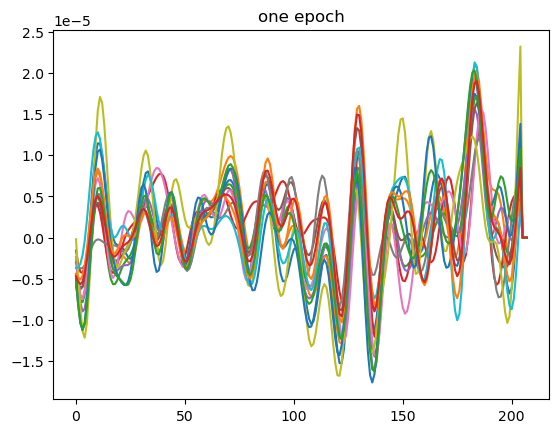

In [27]:
import matplotlib.pyplot as plt

x = root["X"][0]
plt.plot(x.T)
plt.title("one epoch")

### 8. Логи и проверки качества